In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os
import re
import glob
import PIL
import time
import datetime
import gc
from urllib import request
import pathlib
import random
import gzip
import struct

from IPython import display

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/ 

In [3]:
IMG_SHAPE = (28, 28, 1)
LABEL_NUM = 10

In [4]:
dataset_dir = os.environ["HOME"] + "/Workspace/Dataset/mnist/"

In [5]:
!ls $dataset_dir

jpg			   TFRecord
png			   train-images-idx3-ubyte.gz
t10k-images-idx3-ubyte.gz  train-labels-idx1-ubyte.gz
t10k-labels-idx1-ubyte.gz


In [6]:
print()

In [7]:
def load_mnist(x_filename, y_filename, dataset_dir):
    x_path = dataset_dir + x_filename
    y_path = dataset_dir + y_filename
    with gzip.open(x_path) as fx, gzip.open(y_path) as fy:
        fx.read(4)
        fy.read(4)
        N, = struct.unpack('>i', fy.read(4))
        if N != struct.unpack('>i', fx.read(4))[0]:
            raise RuntimeError('wrong pair of MNIST images and labels')
        fx.read(8)

        images = np.empty((N, 784), dtype=np.uint8)
        labels = np.empty(N, dtype=np.uint8)

        for i in range(N):
            labels[i] = ord(fy.read(1))
            for j in range(784):
                images[i, j] = ord(fx.read(1))
    return images.reshape(-1, *IMG_SHAPE), np.eye(LABEL_NUM)[labels]

In [8]:
X_train_valid, y_train_valid = load_mnist("train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz", dataset_dir)
X_test, y_test = load_mnist("t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz", dataset_dir)

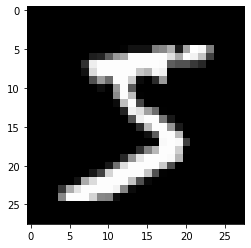

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


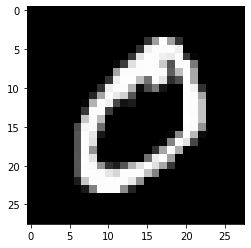

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


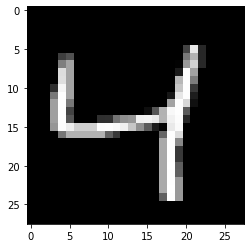

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [9]:
for i in range(3):
    plt.imshow(X_train_valid[i].reshape(28, 28), cmap="gray")
    plt.show()

    print(y_train_valid[i])

In [10]:
ratio_train_valid = 0.8

X_train, X_valid = np.split(X_train_valid, [int(len(X_train_valid) * ratio_train_valid)])
y_train, y_valid = np.split(y_train_valid, [int(len(y_train_valid) * ratio_train_valid)])

In [11]:
BATCH_SIZE = 32

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(len(X_train))
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder = True)   

2022-07-13 18:37:16.309852: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-13 18:37:16.855435: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22300 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:18:00.0, compute capability: 8.6


In [13]:
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
valid_dataset = valid_dataset.shuffle(len(X_valid))
valid_dataset = valid_dataset.batch(BATCH_SIZE, drop_remainder = True)   

In [14]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.shuffle(len(X_test))
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder = True)   

In [88]:
def construct_model(input_shape):
  input = tf.keras.layers.Input(shape = input_shape)
  output = input
  output = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = "same")(output)
  output = tf.keras.layers.ReLU()(output)
  output = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = "same")(output)
  output = tf.keras.layers.ReLU()(output)
  output = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = "same")(output)
  output = tf.keras.layers.ReLU()(output)
  output = tf.keras.layers.Conv2D(filters = LABEL_NUM, kernel_size = 7, padding = "same")(output)
  output = tf.keras.layers.GlobalAveragePooling2D()(output)

  # output = tf.keras.layers.MaxPool2D(strides = 2)(input)
  # output = tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = "same")(output)
  # output = tf.keras.layers.ReLU()(output)
  # output = tf.keras.layers.MaxPool2D(strides = 2)(output)
  # output = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = "same")(output)
  # output = tf.keras.layers.ReLU()(output)
  # output = tf.keras.layers.MaxPool2D(strides = 2)(output)
  # output = tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, padding = "same")(output)
  # output = tf.keras.layers.ReLU()(output)
  # output = tf.keras.layers.Flatten()(output)
  # output = tf.keras.layers.Dense(LABEL_NUM)(output)
  # output = tf.keras.layers.Softmax()(output)
  return tf.keras.Model(inputs = input, outputs = output)

In [89]:
model = construct_model(IMG_SHAPE)

In [90]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
re_lu_8 (ReLU)               (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
re_lu_9 (ReLU)               (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
re_lu_10 (ReLU)              (None, 28, 28, 64)        0   

In [91]:
def loss(y_true, y_pred):
  return tf.keras.metrics.categorical_crossentropy(y_true, y_pred)

In [92]:
def valid_step(model, x_valid, y_valid):
  predictions = model(x_valid)
  loss_value = loss(y_valid, predictions)

  valid_loss(loss_value)
  valid_accuracy(y_valid, predictions)

In [93]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01, beta_1=0.5, beta_2=0.999)

In [94]:
@tf.function
def grad(model, x, y):
  with tf.GradientTape() as tape:
    y_pred = model(x)
    loss_value = loss(y, y_pred)
  grads = tape.gradient(loss_value, model.trainable_variables)
  train_accuracy(y, y_pred)
  return loss_value, grads

In [95]:
!rm -rf ./logs/ 

In [96]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
valid_log_dir = 'logs/gradient_tape/' + current_time + '/valid'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
valid_summary_writer = tf.summary.create_file_writer(valid_log_dir)

In [97]:
# Define our metrics
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
train_accuracy = tf.keras.metrics.CategoricalAccuracy('train_accuracy')
valid_loss = tf.keras.metrics.Mean('valid_loss', dtype=tf.float32)
valid_accuracy = tf.keras.metrics.CategoricalAccuracy('valid_accuracy')

grad_log_dir = 'logs/gradient_tape/' + current_time + '/grad'
grad_summary_writer = tf.summary.create_file_writer(grad_log_dir)

In [98]:
model = construct_model(IMG_SHAPE)

In [99]:
num_epochs = 10

In [100]:
for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

  for x, y in train_dataset:
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    train_loss(loss_value)

    with grad_summary_writer.as_default():
      for i, grad_value in enumerate(grads):
        tf.summary.scalar(f"grad {i}", np.std(grad_value), step=epoch)
      
  with train_summary_writer.as_default():
    tf.summary.scalar('train_loss', train_loss.result(), step=epoch)
    tf.summary.scalar('train_accuracy', train_accuracy.result(), step=epoch)

  for (x_valid, y_valid) in valid_dataset:
    valid_step(model, x_valid, y_valid)
  with valid_summary_writer.as_default():
    tf.summary.scalar('valid_loss', valid_loss.result(), step=epoch)
    tf.summary.scalar('valid_accuracy', valid_accuracy.result(), step=epoch)

  print(f"epoch: {epoch}")

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9


In [101]:
y_pred = model(X_test)
print(tf.keras.metrics.CategoricalAccuracy()(y_pred, y_test))

tf.Tensor(0.1009, shape=(), dtype=float32)


y_pred: 9, y_test: 7


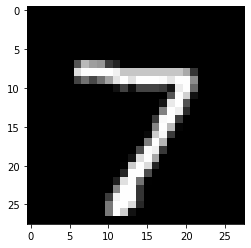

y_pred: 9, y_test: 2


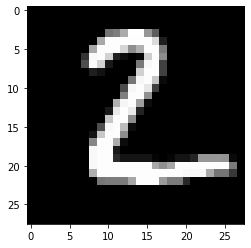

y_pred: 9, y_test: 1


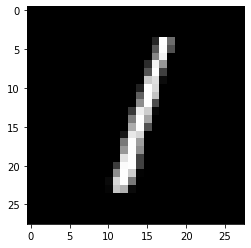

y_pred: 9, y_test: 0


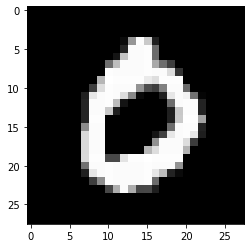

y_pred: 9, y_test: 4


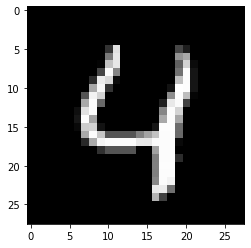

In [102]:
N_test = 5
y_pred = model(X_test[:N_test])

for i in range(N_test):
    print(f"y_pred: {np.argmax(y_pred[i])}, y_test: {np.argmax(y_test[i])}")
    plt.imshow(X_test[i], cmap ="gray")
    plt.show()

In [104]:
print(model.layers[-2].get_weights()[0].shape)

(7, 7, 64, 10)


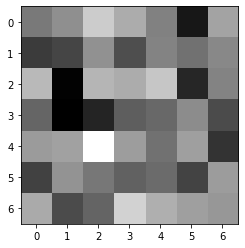

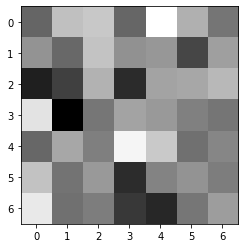

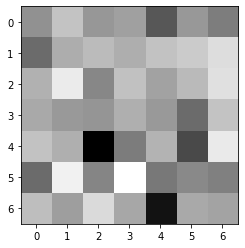

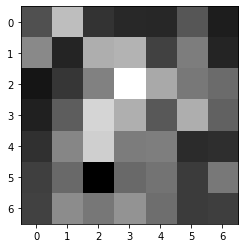

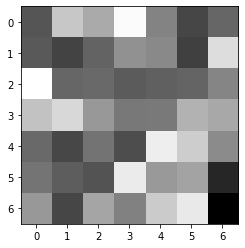

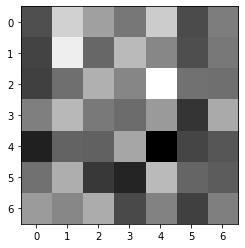

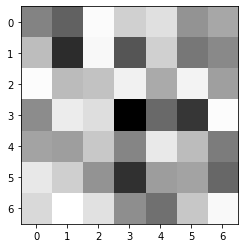

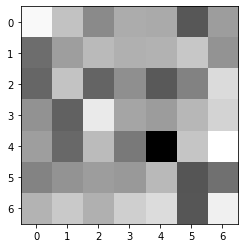

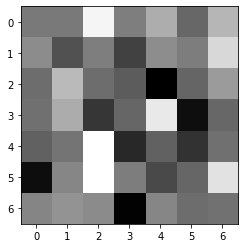

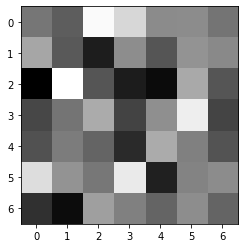

In [105]:
img = np.average(model.layers[-2].get_weights()[0], axis=2)
for i in range(img.shape[2]):
    plt.imshow(img[:,:,i], cmap="gray")
    plt.show()